# Dimensionality Reduction for Housing Data: A PCA-Driven Regression Pipeline
**Author: May Cooper**

## Project Overview
This project utilizes Principal Component Analysis (PCA) to reduce dimensionality in a housing dataset in preparation for linear regression modeling. By transforming correlated input features into a smaller set of uncorrelated principal components, we aim to improve model efficiency and interpretability.

## Research Question
How many principal components are required to retain at least 90% of the variance in the housing dataset and support accurate prediction of property tax values?

## Objective
The objective of this analysis is to determine a reduced set of features using PCA that captures the essential variance in the data. These principal components will be used to build a linear regression model for predicting continuous housing-related outcomes, such as assessed value or tax amount, while minimizing multicollinearity and noise in the input variables.

### Continuous Variables
The following are the continuous variables:
- `SquareFootage`
- `NumBedrooms`
- `NumBathrooms`
- `BackyardSpace`
- `CrimeRate`
- `SchoolRating`
- `DistanceToCityCenter`

Independent Variable: 
- `Price`

These variables are numeric and align with the research question, and do not include any categorical variables.

In [23]:
# Importing necessary libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from statsmodels.api import OLS, add_constant
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

In [24]:
#  Load and Clean Data

file_path = 'D600 Task 3 Dataset 1 Housing Information.csv'
df = pd.read_csv(file_path)

# Keeping dependent variable (Price) and continuous independent variables
dependent_var = 'Price'
continuous_vars = ['SquareFootage', 'NumBathrooms', 'NumBedrooms',
                   'BackyardSpace', 'CrimeRate', 'SchoolRating',
                   'DistanceToCityCenter']
df = df[[dependent_var] + continuous_vars]

# Drop missing values if there is any
df.dropna(inplace=True)

# Save the cleaned dataset (before standardization)
df.to_csv("cleaned_dataset.csv", index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'.")

Cleaned dataset saved as 'cleaned_dataset.csv'.


In [ ]:
# Standardization of Variables

from sklearn.preprocessing import StandardScaler

X = df[continuous_vars]
y = df[dependent_var]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create a DataFrame for standardized data
standardized_df = pd.DataFrame(X_scaled, columns=continuous_vars)
standardized_df[dependent_var] = y.values

# Save the standardized dataset
standardized_df.to_csv("standardized_data.csv", index=False)
print("Standardized dataset saved as 'standardized_data.csv'.")

Standardized dataset saved as 'standardized_data.csv'.


In [ ]:
# Descriptive Statistics

# Calculate stats other than mode
desc_stats = df[[dependent_var] + continuous_vars].describe()

# Calculate mode
modes = df[[dependent_var] + continuous_vars].mode().iloc[0]  # Extract the first mode if multiple exist

# Create a DataFrame to append mode
mode_df = pd.DataFrame(modes).T
mode_df.index = ['Mode']

# Using concat to combine descriptive stats with mode
desc_stats_with_mode = pd.concat([desc_stats, mode_df])

# Save the combined stats
desc_stats_with_mode.to_csv("descriptive_statistics_with_mode.csv", index=True)
print("Saved descriptive stats to csv file for further analysis.")

# Print
print("Descriptive Statistics (including Mode):")
print(desc_stats_with_mode)

Saved descriptive stats to csv file for further analysis.
Descriptive Statistics (including Mode):
              Price  SquareFootage  NumBathrooms  NumBedrooms  BackyardSpace  \
count  7.000000e+03    7000.000000   7000.000000  7000.000000    7000.000000   
mean   3.072820e+05    1048.947459      2.131397     3.008571     511.507029   
std    1.501734e+05     426.010482      0.952561     1.021940     279.926549   
min    8.500000e+04     550.000000      1.000000     1.000000       0.390000   
25%    1.921075e+05     660.815000      1.290539     2.000000     300.995000   
50%    2.793230e+05     996.320000      1.997774     3.000000     495.965000   
75%    3.918781e+05    1342.292500      2.763997     4.000000     704.012500   
max    1.046676e+06    2874.700000      5.807239     7.000000    1631.360000   
Mode   8.500000e+04     550.000000      1.000000     3.000000     300.080000   

         CrimeRate  SchoolRating  DistanceToCityCenter  
count  7000.000000   7000.000000           

In [27]:
# E1: Determine Matrix of All Principal Components

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Save matrix of all principal components
pca_components = pd.DataFrame(pca.components_, columns=continuous_vars)
pca_components.to_csv("pca_components.csv", index=False)

print("Matrix of All Principal Components:")
print(pca_components)

Matrix of All Principal Components:
   SquareFootage  NumBathrooms  NumBedrooms  BackyardSpace  CrimeRate  \
0       0.404460      0.368632     0.415174       0.163634  -0.233355   
1       0.292491      0.328694    -0.465247       0.679390   0.226880   
2       0.186081      0.243094     0.156313      -0.374862   0.859312   
3      -0.220183     -0.138033     0.519589       0.562704   0.260955   
4       0.082830      0.563375    -0.225451      -0.216813  -0.197826   
5       0.756470     -0.565400    -0.103463      -0.040307   0.009802   
6       0.297735      0.202124     0.505209      -0.076566  -0.219829   

   SchoolRating  DistanceToCityCenter  
0      0.569884             -0.349508  
1     -0.253039             -0.113489  
2      0.028099             -0.046006  
3      0.126138              0.511711  
4      0.161433              0.716042  
5      0.099418              0.292858  
6     -0.747368              0.050176  


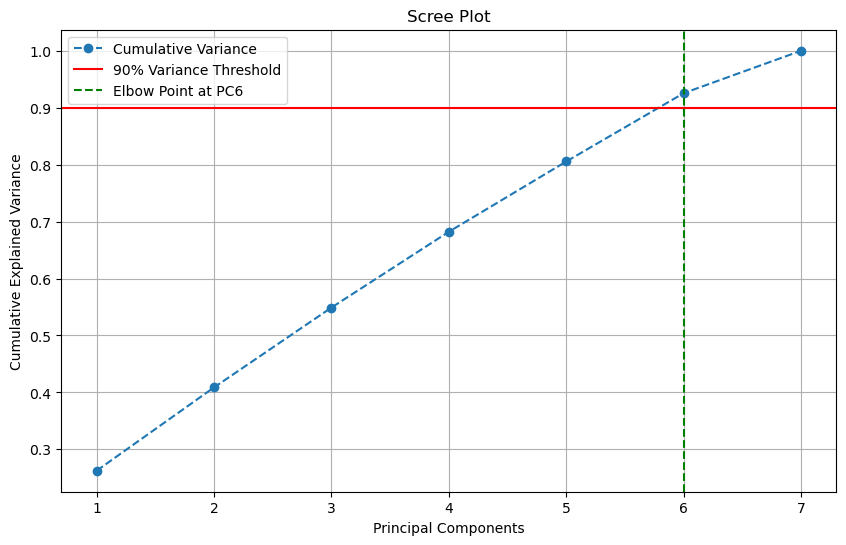

Retained 6 components based on the elbow rule from the scree plot.


In [37]:
# E2: Determine Number of Components to Retain

# Calculate cumulative variance and determine the number of components for 90% explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.90) + 1

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'o--', label='Cumulative Variance')
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Variance Threshold')
plt.axvline(x=n_components, color='g', linestyle='--', label=f'Elbow Point at PC{n_components}')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid()
plt.savefig("scree_plot.png")
plt.show()

# Justification for retained components
print(f"Retained {n_components} components based on the elbow rule from the scree plot.")

In [ ]:
# Variance of each retained principal component
explained_variance_ratio = pca.explained_variance_ratio_
retained_variances = explained_variance_ratio[:n_components]
print("Retained Principal Components Variances:", retained_variances)

Retained Principal Components Variances: [0.26251363 0.14632479 0.14019658 0.13313558 0.12340636 0.11994249]


In [ ]:
# Summarize PCA Results
summary = [
    f"PC{i}: Variance Explained = {var:.4f}"
    for i, var in enumerate(retained_variances, start=1)
]
summary.append(f"Total Variance Explained by {n_components} Components: {cumulative_variance[n_components-1]:.4f}")
summary.append(f"Number of Principal Components Retained: {n_components}")

print("\nPCA Results Summary:")
print("\n".join(summary))


PCA Results Summary:
PC1: Variance Explained = 0.2625
PC2: Variance Explained = 0.1463
PC3: Variance Explained = 0.1402
PC4: Variance Explained = 0.1331
PC5: Variance Explained = 0.1234
PC6: Variance Explained = 0.1199
Total Variance Explained by 6 Components: 0.9255
Number of Principal Components Retained: 6


In [ ]:
# Split dataset into training and testing sets

from sklearn.model_selection import train_test_split
from statsmodels.api import OLS, add_constant
from sklearn.metrics import mean_squared_error

X_pca_reduced = X_pca[:, :n_components]

X_train, X_test, y_train, y_test = train_test_split(X_pca_reduced, y, test_size=0.2, random_state=42)

pd.DataFrame(X_train).to_csv("train_data.csv", index=False)
pd.DataFrame(X_test).to_csv("test_data.csv", index=False)
y_train.to_csv("train_labels.csv", index=False)
y_test.to_csv("test_labels.csv", index=False)

In [ ]:
# Create and perform regression model with backward elimination

def stepwise_ols(X, y, significance_level=0.05):
    X_with_const = add_constant(X)
    selected_vars = list(range(X.shape[1]))
    while True:
        current_model = OLS(y, X_with_const[:, [0] + [v + 1 for v in selected_vars]]).fit()
        p_values = current_model.pvalues[1:]  # exclude intercept
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            variable_to_remove = p_values.argmax()
            selected_vars.pop(variable_to_remove)
        else:
            break
    return current_model, selected_vars

# Fit the model
optimized_model, retained_vars = stepwise_ols(X_train, y_train, significance_level=0.05)

# Output model summary
print("\nOptimized Model Summary:")
print(optimized_model.summary())

# Extract model metrics
adjusted_r2 = optimized_model.rsquared_adj
r2_score = optimized_model.rsquared
f_statistic = optimized_model.fvalue
f_statistic_pvalue = optimized_model.f_pvalue
model_coefficients = optimized_model.params
model_p_values = optimized_model.pvalues

# Print model parameters
print("\nModel Parameters:")
print(f"Adjusted R²: {adjusted_r2:.4f}")
print(f"R²: {r2_score:.4f}")
print(f"F-statistic: {f_statistic:.4f}")
print(f"Probability F-statistic: {f_statistic_pvalue:.4f}")
for name, coef, p_value in zip(optimized_model.model.exog_names, model_coefficients, model_p_values):
    print(f"Coefficient {name}: {coef:.4f}, p-value: {p_value:.4f}")


Optimized Model Summary:
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     1015.
Date:                Tue, 17 Dec 2024   Prob (F-statistic):               0.00
Time:                        07:56:48   Log-Likelihood:                -72675.
No. Observations:                5600   AIC:                         1.454e+05
Df Residuals:                    5593   BIC:                         1.454e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.083e+05   13

In [ ]:
# MSE on training set
y_train_pred = optimized_model.predict(add_constant(X_train[:, retained_vars]))
mse_train = mean_squared_error(y_train, y_train_pred)
print(f"\nMSE on Training Set: {mse_train:.2f}")


MSE on Training Set: 10958658277.13


In [ ]:
# MSE on test set
y_test_pred = optimized_model.predict(add_constant(X_test[:, retained_vars]))
mse_test = mean_squared_error(y_test, y_test_pred)
print(f"MSE on Test Set: {mse_test:.2f}")

MSE on Test Set: 10570786098.53
